<a href="https://colab.research.google.com/github/WoojinJeonkr/DeepLearning/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# tf.keras를 사용한 Neural Style Transfer
- 딥러닝을 사용하여 원하는 이미지를 다른 스타일의 이미지로 구성
- 이미지의 콘텐츠를 특정 스타일에 최적화시키는 방식으로 작동
- 콘텐츠 이미지와 (유명한 작가의 삽화와 같은) 스타일의 참조 이미지를 이용하여,  
 콘텐츠 이미지의 콘텐츠는 유지하되 스타일 참조 이미지의 화풍으로 채색한 것 같은 새로운 이미지를 생성하는 최적화 기술
- 출력 이미지를 콘텐츠 이미지의 콘텐츠 통계랑(statistic)과 스타일 참조 이미지의 스타일 통계량에 맞춰 최적화시킴으로써 구현
- 통계량은 합성곱 신경망을 이용해 각각의 이미지에서 추출

## 01. 모듈 구성 및 임포트

In [1]:
import tensorflow as tf

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [4]:
# 콘텐트 이미지 다운로드
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# 스타일 이미지 다운로드
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

204800/195196 [===============================] - 0s 0us/step


## 02. 입력 시각화

In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [6]:
# 이미지 출력 함수
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

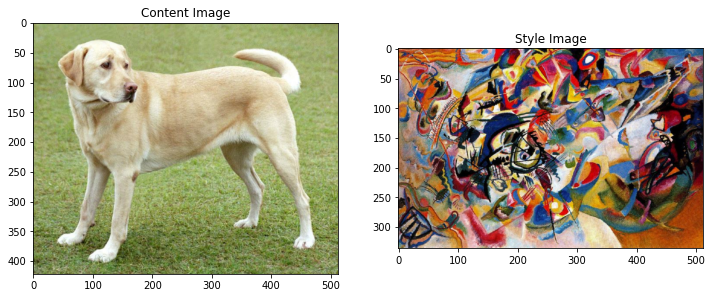

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## 03. TF-Hub를 통한 스타일 전이

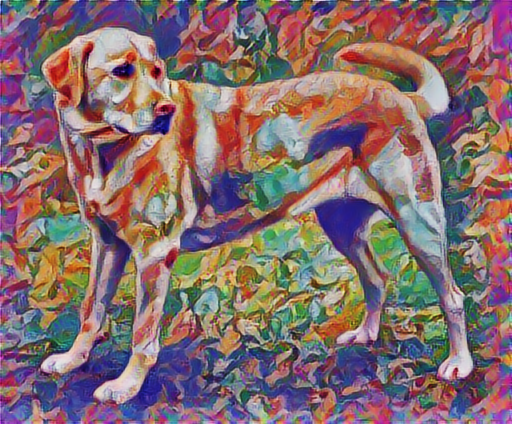

In [8]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## 04. 콘텐츠와 스타일 표현 정의

In [9]:
# vgg19 모델 사용
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574726144/574710816 [==============================] - 5s 0us/step


TensorShape([1, 1000])

In [10]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 0us/step


[('Labrador_retriever', 0.4931729),
 ('golden_retriever', 0.23665176),
 ('kuvasz', 0.036357265),
 ('Chesapeake_Bay_retriever', 0.024182765),
 ('Greater_Swiss_Mountain_dog', 0.018646065)]

In [11]:
# 분류층을 제외한 vgg19 모델 불러오고 층 이름 확인
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80150528/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
# 이미지 스타일과 콘텐츠를 나타내기 위해 층 선택
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## 05. 모델 생성

In [13]:
def vgg_layers(layer_names):
  # 이미지넷 데이터셋에 사전학습된 VGG 모델 불러오기
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [14]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# 각 층의 출력에 대한 통계량
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  크기: ", output.numpy().shape)
  print("  최솟값: ", output.numpy().min())
  print("  최댓값: ", output.numpy().max())
  print("  평균: ", output.numpy().mean())
  print()

block1_conv1
  크기:  (1, 336, 512, 64)
  최솟값:  0.0
  최댓값:  835.5255
  평균:  33.97525

block2_conv1
  크기:  (1, 168, 256, 128)
  최솟값:  0.0
  최댓값:  4625.887
  평균:  199.82687

block3_conv1
  크기:  (1, 84, 128, 256)
  최솟값:  0.0
  최댓값:  8789.24
  평균:  230.78099

block4_conv1
  크기:  (1, 42, 64, 512)
  최솟값:  0.0
  최댓값:  21566.135
  평균:  791.24005

block5_conv1
  크기:  (1, 21, 32, 512)
  최솟값:  0.0
  최댓값:  3189.2537
  평균:  59.179478



## 06. 스타일 계산
- 이미지의 콘텐츠는 중간층들의 특성 맵(feature map)의 값들로 표현
- 이미지의 스타일은 각 특성 맵의 평균과 피쳐맵들 사이의 상관관계로 설명 가능

In [15]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## 07. 스타일과 콘텐츠 추출
- 스타일과 콘텐츠 텐서를 반환하는 모델 생성

In [16]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [17]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

In [18]:
print('스타일:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())

스타일:
   block1_conv1
    크기:  (1, 64, 64)
    최솟값:  0.0055228495
    최댓값:  28014.562
    평균:  263.79022

   block2_conv1
    크기:  (1, 128, 128)
    최솟값:  0.0
    최댓값:  61479.484
    평균:  9100.949

   block3_conv1
    크기:  (1, 256, 256)
    최솟값:  0.0
    최댓값:  545623.4
    평균:  7660.976

   block4_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  4320501.0
    평균:  134288.86

   block5_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  110005.37
    평균:  1487.0378

콘텐츠:
   block5_conv2
    크기:  (1, 26, 32, 512)
    최솟값:  0.0
    최댓값:  2410.8794
    평균:  13.764149


## 08. 경사하강법 실행
- 스타일과 콘텐츠 추출기를 사용해 스타일 전이 알고리즘을 구현
- 타깃에 대한 입력 이미지의 평균 제곱 오차를 계산한 후, 오차값들의 가중합 구하기

In [19]:
# 스타일과 콘텐츠 타깃값 지정
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [20]:
# 최적화할 이미지를 담을 tf.Variable 정의 후 콘텐츠 이미지 초기화
image = tf.Variable(content_image)

In [21]:
# 픽셀 값이 실수이므로 0에서 1 사이로 클리핑하는 함수 정의
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [22]:
# optimizer 생성
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [23]:
# 최적화를 진행하기 위해, 전체 오차를 콘텐츠와 스타일 오차의 가중합으로 정의
style_weight=1e-2
content_weight=1e4

In [24]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [26]:
# tf.GradientTape를 사용해 이미지 업데이트
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

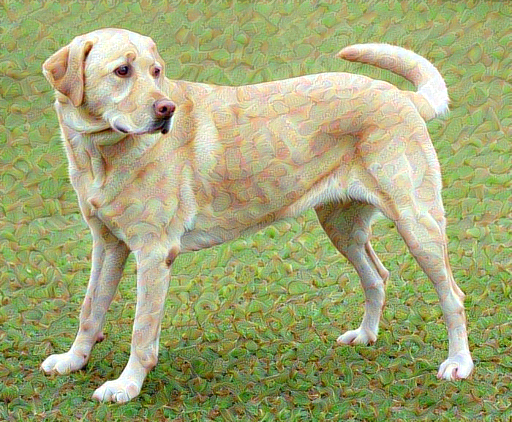

In [27]:
# 구현한 알고리즘 시험
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

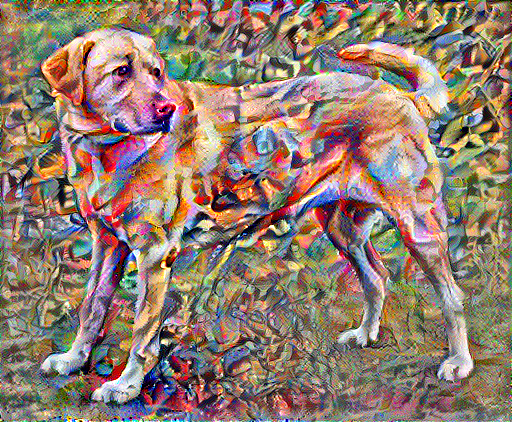

훈련 스텝: 800
.......................................................................................................................................................

In [ ]:
# 이미지 최적화 실행
import time
start = time.time()

epochs = 20
steps_per_epoch = 200

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))